## **Reinforcement Learning with a Custom Pygame Environment**

This notebook implements a Reinforcement Learning agent in a custom-designed environment inspired by FrozenLake. The environment is built from scratch using "pygame", and includes hand-drawn tile graphics and custom game mechanics.

What’s included:
- Grid-based map with start, goal, obstacles, and slippery tiles
- Agent movement, state tracking, and environment transitions
- Manual implementation of an epsilon-greedy exploration policy
- Q-value updates and reward tracking per episode
- Game visualization and GIF export using "pygame" and "imageio"

In [1]:
!pip install numpy
!pip install imageio
!pip install pygame
!pip install tqdm

In [2]:
import numpy as np
from tqdm import tqdm

# To visualize
import pygame
import imageio
from PIL import Image
import IPython
import os

os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.6.1 (SDL 2.28.4, Python 3.11.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Upload img.zip
from google.colab import files

uploaded = files.upload()

Saving img.zip to img.zip


In [4]:
!unzip img.zip

Archive:  img.zip
   creating: img/
  inflating: __MACOSX/._img          
  inflating: img/goal.png            
  inflating: __MACOSX/img/._goal.png  
  inflating: img/elf_left.png        
  inflating: __MACOSX/img/._elf_left.png  
  inflating: img/elf_right.png       
  inflating: __MACOSX/img/._elf_right.png  
  inflating: img/hole.png            
  inflating: __MACOSX/img/._hole.png  
  inflating: img/rock.png            
  inflating: __MACOSX/img/._rock.png  
  inflating: img/stool.png           
  inflating: __MACOSX/img/._stool.png  
  inflating: img/elf_up.png          
  inflating: __MACOSX/img/._elf_up.png  
  inflating: img/ice.png             
  inflating: __MACOSX/img/._ice.png  
  inflating: img/elf_down.png        
  inflating: __MACOSX/img/._elf_down.png  
  inflating: img/cracked_hole.png    
  inflating: __MACOSX/img/._cracked_hole.png  


### Q-Learning

In [5]:
window_size = (512, 512)

hole_image = pygame.image.load("img/cracked_hole.png")
rock_image = pygame.image.load("img/rock.png")
ice_image = pygame.image.load("img/ice.png")
goal_image = pygame.image.load("img/goal.png")
start_image = pygame.image.load("img/stool.png")
elfs = [
    "img/elf_left.png",
    "img/elf_down.png",
    "img/elf_right.png",
    "img/elf_up.png",
]
elf_images = [pygame.image.load(f_name) for f_name in elfs]

pygame.init()
pygame.display.init()
pygame.display.set_caption("SlipperyFrozenLake")

window_surface = pygame.Surface(window_size)
cell_width = 64
cell_height = 64
smaller_cell_scale = 1
small_cell_width = int(cell_width * smaller_cell_scale)
small_cell_height = int(cell_height * smaller_cell_scale)

def _center_small_rect(big_rect, small_dims):
    offset_w = (big_rect[2] - small_dims[0]) / 2
    offset_h = (big_rect[3] - small_dims[1]) / 2
    return (
        big_rect[0] + offset_w,
        big_rect[1] + offset_h,
    )

def render(lake, row, col, a_prev):
    #elf_img = elf_images[a_prev]
    elf_img = pygame.transform.scale(elf_images[a_prev], (cell_width, cell_height))
    hole_img = pygame.transform.scale(hole_image, (cell_width, cell_height))
    rock_img = pygame.transform.scale(rock_image, (cell_width, cell_height))
    ice_img = pygame.transform.scale(ice_image, (cell_width, cell_height))
    goal_img = pygame.transform.scale(goal_image, (cell_width, cell_height))
    start_img = pygame.transform.scale(start_image, (small_cell_width, small_cell_height))

    for y in range(8):
        for x in range(8):
            rect = (x * cell_width, y * cell_height, cell_width, cell_height)
            if lake[y][x] == "H":
                window_surface.blit(hole_img, (rect[0], rect[1]))
            elif lake[y][x] == "R":
                window_surface.blit(rock_img, (rect[0], rect[1]))
            elif lake[y][x] == "G":
                window_surface.blit(ice_img, (rect[0], rect[1]))
                goal_rect = _center_small_rect(rect, goal_img.get_size())
                window_surface.blit(goal_img, goal_rect)
            elif lake[y][x] == "S":
                window_surface.blit(ice_img, (rect[0], rect[1]))
                stool_rect = _center_small_rect(rect, start_img.get_size())
                window_surface.blit(start_img, stool_rect)
            else:
                window_surface.blit(ice_img, (rect[0], rect[1]))

            pygame.draw.rect(window_surface, (180, 200, 230), rect, 1)

    cell_rect = (
        col * cell_width,
        row * cell_height,
        cell_width,
        cell_height,
    )

    elf_rect = _center_small_rect(cell_rect, elf_img.get_size())
    window_surface.blit(elf_img, elf_rect)
    return np.transpose(np.array(pygame.surfarray.pixels3d(window_surface)), axes=(1, 0, 2))

#### **Environment Description**
We implement a Q-learning framework to train an agent on SlipperyFrozenLake, a modified version of the FrozenLake environment from the "gym" library. The environment is defined as follows:

- The agent starts at the starting point (S) and aims to reach the goal (G) while avoiding holes (H).
- The agent has four possible actions: Left (0), Down (1), Right (2), and Up (3).
- Upon selecting an action, the agent moves in the chosen direction until one of the following conditions is met:
    1. The agent is blocked by a rock (R).
    2. The agent reaches the boundary of the lake.
    3. The agent encounters a hole (H), which should be avoided.
    4. The agent reaches the goal (G), which is the desired outcome.


We use the following map:

In [6]:
lake = [
    "S-----R-",
    "-H-R---R",
    "R----R--",
    "-HR-RH--",
    "R----R-R",
    "-R------",
    "-H------",
    "-R-HG-R-"
]

In [7]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

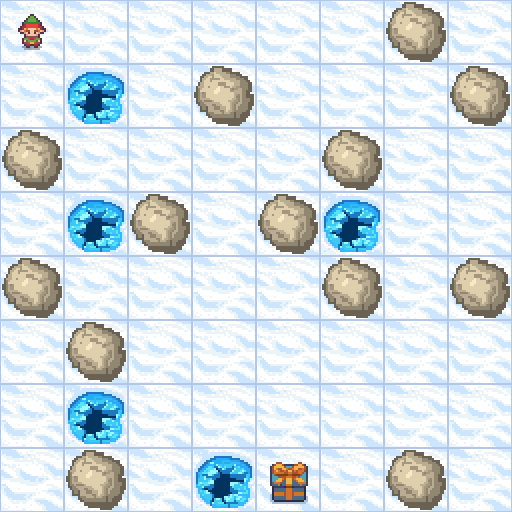

In [8]:
rgb_array = render(lake, 0, 0, DOWN)
img = Image.fromarray(rgb_array)
img

In [9]:
# The `next_step` function calculates the (next_state, reward, terminate) tuple for a given (state, action) pair.
# The agent receives a reward of +10 only when it reaches the goal.
def next_step(row, col, action):
    reward = 0
    terminate = False

    while True:
        if lake[row][col] == "H":
            terminate = True
            break
        if lake[row][col] == "G":
            terminate = True
            reward = 10.0
            break
        if lake[row][col] == "R":
            if action == LEFT:
                col += 1
            elif action == RIGHT:
                col -= 1
            elif action == UP:
                row += 1
            elif action == DOWN:
                row -= 1
            break
        if action == LEFT and col == 0:
            break
        elif action == RIGHT and col == 7:
            break
        elif action == UP and row == 0:
            break
        elif action == DOWN and row == 7:
            break
        if action == LEFT:
            col -= 1
        elif action == RIGHT:
            col += 1
        elif action == UP:
            row -= 1
        elif action == DOWN:
            row += 1

    return (row, col), reward, terminate

In [10]:
# Some manually made testcases to check "next_step"
assert next_step(0, 0, RIGHT) == ((0, 5), 0, False)
assert next_step(0, 0, UP) == ((0, 0), 0, False)
assert next_step(3, 7, LEFT) == ((3, 5), 0, True)
assert next_step(6, 4, DOWN) == ((7, 4), 10, True)
print("Sanity check done!")

Sanity check done!


In [11]:
q_table = np.zeros((64, 4))

In [12]:
def to_s(row, col):
    return row * 8 + col

In [13]:
def epsilon_greedy(row, col, q_table, epsilon):
    if np.random.rand() < epsilon:
        a = np.random.randint(4)
    else:
        s = to_s(row, col)
        a_candidates = np.where(q_table[s] == q_table[s].max())[0]
        a = np.random.choice(a_candidates)
    return a

### Training the agent


In [14]:
# Gif file of the agent's movement based on the input q_table
def movement_gif(file, q_table):
    row = 0
    col = 0
    done = False
    images = []

    rgb_array = render(lake, 0, 0, DOWN)
    img = Image.fromarray(rgb_array)
    for _ in range(4):
        images.append(img)

    while not done:
        a = epsilon_greedy(row, col, q_table, 0)

        s = to_s(row, col)
        (row, col), r, done = next_step(row, col, a)

        rgb_array = render(lake, row, col, a)
        img = Image.fromarray(rgb_array)
        images.append(img)

    for _ in range(7):
        images.append(img)

    imageio.mimsave(file, [np.array(img) for i, img in enumerate(images)], fps=2)

In [15]:
np.random.seed(123)
movement_gif("lake_untrained.gif", q_table)

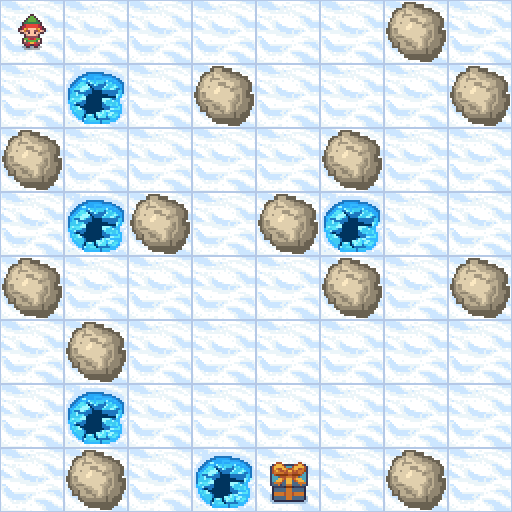

In [16]:
IPython.display.Image(filename="lake_untrained.gif")

Agent fails to reach the goal

In [17]:
learning_rate = 0.1
discount_rate = 0.8

In [18]:
def train_episode(epsilon):
    row = 0
    col = 0
    done = False

    while not done:
        a = epsilon_greedy(row, col, q_table, epsilon)
        (row_new, col_new), r, done = next_step(row, col, a)
        s = to_s(row, col)
        s_next = to_s(row_new, col_new)
        value_old = q_table[s, a]
        value_learned = r + discount_rate * np.max(q_table[s_next])
        q_table[s, a] = (1 - learning_rate) * value_old + learning_rate * value_learned
        row = row_new
        col = col_new

def train(num_epoch=10000):
    for i in tqdm(range(num_epoch)):
        train_episode(1 / (i + 1))

In [19]:
train()

100%|██████████| 10000/10000 [00:03<00:00, 2612.21it/s]


In [20]:
q_table

array([[8.58993459e-02, 1.92413213e-02, 1.07374182e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.78035596e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.68185595e-07, 1.34217728e+00, 0.00000000e+00, 2.13698080e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.32786484e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.55013683e-01, 1.67772160e

In [21]:
def test_episode():
    row = 0
    col = 0
    reward_total = 0
    done = False

    while not done:
        a = epsilon_greedy(row, col, q_table, 0)
        (row_new, col_new), r, done = next_step(row, col, a)
        row = row_new
        col = col_new
        reward_total += r

    return reward_total

def test(num_epoch=10000):
    list_reward = []
    for i in tqdm(range(num_epoch)):
        reward = test_episode()
        list_reward.append(reward)
    reward_average = np.mean(list_reward)
    return reward_average

In [22]:
test()

100%|██████████| 10000/10000 [00:02<00:00, 3917.04it/s]


np.float64(10.0)

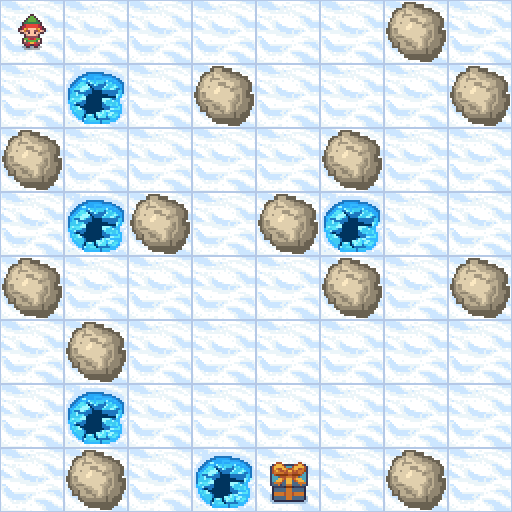

In [23]:
movement_gif("lake_trained.gif", q_table)

IPython.display.Image(filename="lake_trained.gif")

## Conclusion

This project was a hands-on way to understand reinforcement learning by manually implementing both the environment and the learning algorithm.

Key takeaways:
- The epsilon-greedy strategy balances exploration and exploitation effectively in grid environments.
- Custom environments require careful handling of states, transitions, and visual feedback.
- Building from scratch (including graphics and movement logic) offers a deeper understanding of agent-environment interaction.
- Even simple Q-value updates can lead to clear learning over time when visualized.
